# This notebook analyse monsoon variables. 

In [1]:
'''Import packages for loading data, analysing, and plotting'''

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xesmf as xe
%matplotlib inline
import cartopy
import cartopy.crs as ccrs
import matplotlib
from netCDF4 import Dataset
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy.ma as ma
import math
import xlrd
import os
import matplotlib.colors as colors
import seaborn as sns
import scipy

In [2]:
#Define monsoon names
monsoonlist=['NAMS','NAF','SAS','EAS','SAMS','SAF','AUSMC']

In [9]:
 #No change needs here
 #PMIP model list used in this notebook represents CMIP models included in PMIP
'''Define CMIP list'''

def whole_model_list():
    filename_xls='PMIP & CMIP model data status.xlsx'
    wb=xlrd.open_workbook(filename_xls)
    sh_pmip4 = wb.sheet_by_name('PMIP4-CMIP6')
    model_id4=sh_pmip4.col_values(14, 6, 28)
    cmip6=[]
    cmip6_generation=sh_pmip4.col_values(20, 6, 28)
    pmip4_generation=sh_pmip4.col_values(21, 6, 28)
    for i in range(len(model_id4)):
        if (cmip6_generation[i]=='CMIP6' and pmip4_generation[i]=='PMIP4'):
            cmip6.append(model_id4[i])
    cmip5=[]
    sh_pmip3 = wb.sheet_by_name('PMIP3-CMIP5')
    model_id3=sh_pmip3.col_values(12, 2, 20)
    cmip5_generation=sh_pmip3.col_values(18, 2, 20)
    pmip3_generation=sh_pmip3.col_values(19, 2, 20)
    for i in range(len(model_id3)):
        if (cmip5_generation[i]=='CMIP5' and pmip3_generation[i]=='PMIP3'):
            cmip5.append(model_id3[i])
    return model_id4,cmip6,model_id3,cmip5

#PMIP4-CMIP6
#Cell range: B6 - X28
#Below: No values are corresponed No in python
# model row No.: 6-27
# col_No. col.  experiment/column content

#    4      E    0kpiControl
#    5      F    LMpast1000(1000 years)
#    6      G    6kmidHolocene
#    7      H    21klgm
#    8      I    Last Interglaciallig127k
#    9      J    Mid Pliocene warm periodmidPliocene-eoi400

#    14     O    Model id
#    20     U    CMIP6
#    21     V    PMIP4

#PMIP3-CMIP5
#Cell range: B2 - U20
#Below: No values are corresponed No in python
# model row No.: 2-19
# col_No. col.  experiment/column content

#    3      D    0kpiControl
#    4      E    LMpast1000(1000 years)
#    5      F    6kmidHolocene
#    6      G    21klgm
#    7      H    Last Interglaciallig127k
#    8      I    Mid Pliocene warm periodmidPliocene-eoi400   

#    12     M    Model id
#    18     S    CMIP6
#    19     T    PMIP4


pmip4,cmip6,pmip3,cmip5=whole_model_list()

pmip={}
pmip['PMIP3']=cmip5
pmip['PMIP4']=cmip6

pmip_v4='PMIP4'
pmip_v3='PMIP3'

In [3]:
#model namelist

pmip_v3='PMIP3'
pmip_v4='PMIP4'
pmip={}
pmip['PMIP4']=['AWI-CM-1-1-LR',
               'CESM2',
               'EC-EARTH-3-3',
               'FGOALS-f3-L',
               'FGOALS-g3',
               'GISS-E2-1-G',
               'HadGEM3-GC31',
               'IPSL-CM6A-LR',
               'MIROC-ES2L',
               'MPI-ESM1-2-LR',
               'MRI-ESM2-0',
               'NESM3',
               'NorESM1-F',
               'NorESM2',
               'UofT-CCSM-4']
pmip['PMIP3']=['BCC-CSM1-1',
               'CCSM4',
               'CNRM-CM5',
               'CSIRO-Mk3L-1-2',
               'CSIRO-Mk3-6-0',
               'EC-EARTH-2-2',
               'FGOALS-g2',
               'FGOALS-s2',
               'GISS-E2-R',
               'HadGEM2-CC',
               'HadGEM2-ES',
               'IPSL-CM5A-LR',
               'KCM1-2-2',
               'MIROC-ESM',
               'MPI-ESM-P',
               'MRI-CGCM3']
               
               
               
  





In [4]:
#No change needs here

'''Define calculating functions, same as in Ensemble one with slight changes applied to fit monsoon calculations'''

#This function will get all available experiment names
def experimentlist():
    exps=[]
    file_path = "data" 
    for dirpaths, dirnames, filenames in os.walk(file_path):
        for d in dirnames:
            exps.append(d)
    return exps

#This function will get all available model names in the experiment 
def modellist(experiment_name):
    models=[]
    file_path = "data/%s" %(experiment_name)
    for dirpaths, dirnames, filenames in os.walk(file_path):
        for f in filenames:
            mname=f.split("_")[0]
            models.append(mname)
    return models

#This function will get all available filenames in the experiment 
def filenamelist(experiment_name):
    filenames=[]
    file_path = "data/%s" %(experiment_name)
    for dirpaths, dirnames, files in os.walk(file_path):
        for f in files:
            ff='data/%s/%s'%(experiment_name,f)
            filenames.append(ff)
    return filenames


def identify_ensemble_members(variable_name,experiment_name):
    datadir="data/%s" %(experiment_name)
    ensemble_members=!scripts/find_experiment_ensemble_members.bash {experiment_name} {variable_name} {datadir}
    return ensemble_members

def extract_model_name(filename):
    file_no_path=filename.rpartition("/")
    file_strings=file_no_path[2].partition("_")
    model_name=file_strings[0]
    return model_name

def ensemble_members_dict(variable_name,experiment_name):
    ens_mems=identify_ensemble_members(variable_name,experiment_name)
    ens_mems_dict={extract_model_name(ens_mems[0]):ens_mems[0]}
    for mem in ens_mems[1:]:
        ens_mems_dict[extract_model_name(mem)]=mem
    return ens_mems_dict
    
def monsoon_mean(pmip_v):
    model_list=[]
    n=0
    average=0
    grid_1x1= xr.Dataset({'lat': (['lat'], np.arange(-89.5, 90., 1.0)),
                         'lon': (['lon'], np.arange(0, 360, 1.0))})
    gcm_dict=ensemble_members_dict(variable_name,experiment_name)
    for gcm in gcm_dict:
        if gcm in pmip[pmip_v]:
            model_list.append(gcm)
            this_file=xr.open_dataset(gcm_dict.get(gcm),decode_times=False)
            this_var=this_file[variable_name]
            new_var=this_var.fillna(0)
            this_regridder=xe.Regridder(this_file,grid_1x1,'bilinear', reuse_weights=True,periodic=True) 
            var_1x1=this_regridder(new_var)
            average=(n*average+var_1x1)/(n+1)
            n=n+1
    aaa=average.where(average >2.0)
    ensemble_ave_r=np.zeros((180,360))
    for r in range(180):
        for c in range(360):
            ensemble_ave_r[r][c]=aaa[r][c-180] 
    f3='model_lists/%s_%s_%s_ave_modellist.csv' %(experiment_name,variable_name,pmip_v)
    modellist=pd.DataFrame(model_list)
    modellist.to_csv(f3)
    return ensemble_ave_r

def monsoon_mean_boundary(pmip_v):
    n=0
    average=0
    grid_1x1= xr.Dataset({'lat': (['lat'], np.arange(-89.5, 90., 1.0)),
                         'lon': (['lon'], np.arange(0, 360, 1.0))})
    gcm_dict=ensemble_members_dict(variable_name,experiment_name)
    for gcm in gcm_dict:
        if gcm in pmip[pmip_v]:
            this_file=xr.open_dataset(gcm_dict.get(gcm),decode_times=False)
            this_var=this_file[variable_name]
            new_var=this_var.fillna(0)
            this_regridder=xe.Regridder(this_file,grid_1x1,'bilinear', reuse_weights=True,periodic=True) 
            var_1x1=this_regridder(new_var)
            average=(n*average+var_1x1)/(n+1)
            n=n+1
    aaa=average.where(average >2.0)
    ensemble_ave_r=np.zeros((180,360))
    for r in range(180):
        for c in range(360):
            ensemble_ave_r[r][c]=aaa[r][c-180]     
    bbb=pd.DataFrame(ensemble_ave_r)
    ccc=np.array(bbb.fillna(3000))
    return ccc



y= np.arange(-89.5, 90., 1.0)
x=np.arange(-180, 180., 1.0)

def domain_obs():
    obs_file=xr.open_dataset('data/C20-Reanalysis.cvdp_data.1871-2012.nc',decode_times=False)
    domain=obs_file['monsoon_domain']
    grid_1x1= xr.Dataset({'lat': (['lat'], np.arange(-89.5, 90., 1.0)),
                             'lon': (['lon'], np.arange(0, 360, 1.0))})
    this_regridder=xe.Regridder(obs_file,grid_1x1,'bilinear', reuse_weights=True,periodic=True) 
    obs_domain=this_regridder(domain)
    domain_r=np.zeros((180,360))
    for r in range(180):
        for c in range(360):
            domain_r[r][c]=obs_domain[r][c-180]
    ax=pd.DataFrame(domain_r)
    DO=np.array(ax.fillna(3000))
    return DO

def monsoon_mean_diffence(pmip_v):
    model_list=[]
    n=0
    average=0
    A_dict=ensemble_members_dict(variable_name,experiment_name)
    B_dict=ensemble_members_dict(variable_name,'piControl')
    grid_1x1= xr.Dataset({'lat': (['lat'], np.arange(-89.5, 90., 1.0)),
                         'lon': (['lon'], np.arange(0, 360., 1.0))})
    for gcm in A_dict:
        if gcm in B_dict:
            if gcm in pmip[pmip_v]:
                model_list.append(gcm)
                expt_a_file=xr.open_dataset(A_dict.get(gcm),decode_times=False)
                expt_a=expt_a_file[variable_name]
                new_a=expt_a.fillna(0)
                expt_b_file=xr.open_dataset(B_dict.get(gcm),decode_times=False)
                expt_b=expt_b_file[variable_name]
                new_b=expt_b.fillna(0)
                diff=new_a-new_b
                this_regridder=xe.Regridder(expt_a_file,grid_1x1,'bilinear', reuse_weights=True,periodic=True) 
                diff_1x1=this_regridder(diff)
                average=(n*average+diff_1x1)/(n+1)
                n=n+1
    aaa=average.where(average !=0)
    ensemble_diff_r=np.zeros((180,360))
    for r in range(180):
        for c in range(360):
            ensemble_diff_r[r][c]=aaa[r][c-180]
    f3='model_lists/%s_%s_%s_avediff_modellist.csv' %(experiment_name,variable_name,pmip_v)
    modellist=pd.DataFrame(model_list)
    modellist.to_csv(f3)
    return ensemble_diff_r

In [5]:
'''Define plotting function'''
def domian_plot(data,experiment_name):
    cmap=plt.get_cmap('hsv')
    bounds = np.linspace(2, 20, 10)
    norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
    plt.figure(figsize=(18,10))
    title='%s' %(experiment_name)
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0.0, globe=None))
    plt.title(title)
    ax.set_ylim([-40,60])
    ax.coastlines()
    ax.gridlines()
    fig=ax.contourf(x,y,data,levels=bounds, transform=ccrs.PlateCarree(),cmap=cmap,norm=norm)
    
    ax.contour(x,y,DO, levels=[100,110], colors='k', linestyles='-')
    cax,kw = matplotlib.colorbar.make_axes(ax,location='bottom',pad=0.05,shrink=0.7)
    plt.colorbar(fig,cax=cax,extend='both',**kw)
    figname='figs/%s_%s_domain.png' %(experiment_name,variable_name)
    plt.savefig(figname)
    

def domain_diff_plot(data,experiment_name):
    cmap=plt.get_cmap('RdYlBu_r')
    clim=[-8,8]
    bounds = np.linspace(-8, 8, 11)
    norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
    plt.figure(figsize=(18,10))
    title='GMD_PMIP4_diff'
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0.0, globe=None))
    plt.title(title)
    ax.set_ylim([-40,60])
    ax.coastlines()
    ax.gridlines()
    fig=ax.contourf(x,y,data, transform=ccrs.PlateCarree(),cmap=cmap,norm=norm,vmin=-8,vmax=8)
    fig.set_clim(-6,6)
    ax.contour(x,y,DO, levels=[100,110], colors='k', linestyles='-')
    cax,kw = matplotlib.colorbar.make_axes(ax,location='bottom',pad=0.05,shrink=0.7)
    plt.colorbar(fig,cax=cax,extend='both',**kw)
    figname='figs/%s_%s_domiandiff.png' %(experiment_name,variable_name)
    plt.savefig(figname)


# Calculations -- PMIP4 Global monsoon domain
This section calculate and plot ensemble mean change in global monsoon domian(Ensemble mean of PMIP4 simulated global mean domain for midHolocene(Top), piControl (middle) and changes between them (bottom). Domain regions are marked as values > 2.5 mm/day. Thick contour (black)shows the boundary of observed domain at present.

In [6]:
experiment_name='midHolocene'
variable_name='monsoon_domain'


In [7]:
# This section calculate global monsoon domain in midHolocene
GMD_mh=monsoon_mean(pmip_v4) 
DO=domain_obs()

Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_192x288_180x360_peri.nc
Reuse existing file: bilinear_90x144_180x360_peri.nc
Reuse existing file: bilinear_144x192_180x360_peri.nc
Reuse existing file: bilinear_143x144_180x360_peri.nc
Reuse existing file: bilinear_64x128_180x360_peri.nc
Reuse existing file: bilinear_160x320_180x360_peri.nc
Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_96x144_180x360_peri.nc
Reuse existing file: bilinear_192x288_180x360_peri.nc
Reuse existing file: bilinear_94x192_180x360_peri.nc


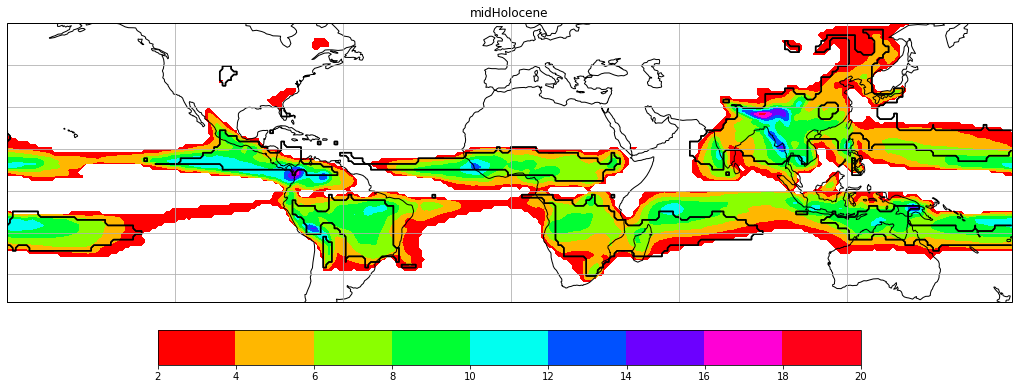

In [8]:
# Ensemble mean of PMIP4 midHolocene global monsoon domain
# Thick contour (black) shows observed domian in present-day 
domian_plot(GMD_mh,experiment_name)

In [9]:
# Same as above but for piControl
experiment_name='piControl'
variable_name='monsoon_domain'

GMD_pi=monsoon_mean(pmip_v4)

Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_192x288_180x360_peri.nc
Reuse existing file: bilinear_90x144_180x360_peri.nc
Reuse existing file: bilinear_144x192_180x360_peri.nc
Reuse existing file: bilinear_143x144_180x360_peri.nc
Reuse existing file: bilinear_64x128_180x360_peri.nc
Reuse existing file: bilinear_160x320_180x360_peri.nc
Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_96x144_180x360_peri.nc
Reuse existing file: bilinear_192x288_180x360_peri.nc


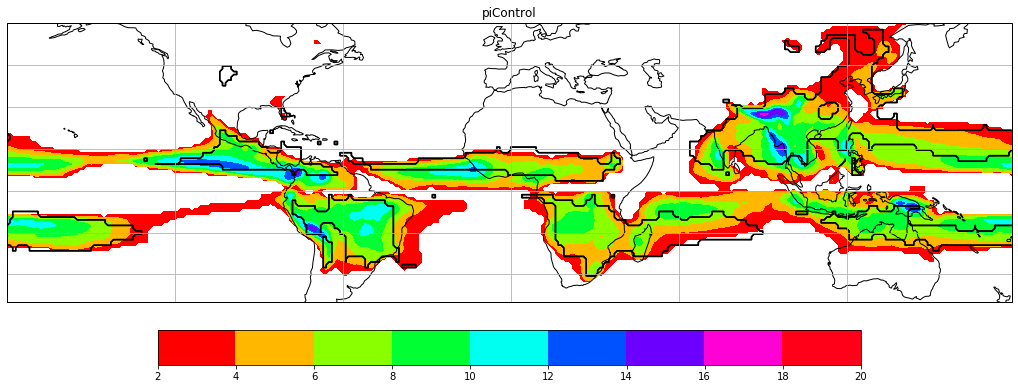

In [10]:
# Ensemble mean of PMIP4 piControl global monsoon domain
# Thick contour (black) shows observed domian in present-day 
domian_plot(GMD_pi,experiment_name)

In [11]:
# Ensemble mean of changes in PMIP4 global monsoon domain (midHolocene - piControl)
 
experiment_name='midHolocene'
GMD_diff=monsoon_mean_diffence(pmip_v4)

Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_192x288_180x360_peri.nc
Reuse existing file: bilinear_90x144_180x360_peri.nc
Reuse existing file: bilinear_144x192_180x360_peri.nc
Reuse existing file: bilinear_143x144_180x360_peri.nc
Reuse existing file: bilinear_64x128_180x360_peri.nc
Reuse existing file: bilinear_160x320_180x360_peri.nc
Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_96x144_180x360_peri.nc
Reuse existing file: bilinear_192x288_180x360_peri.nc


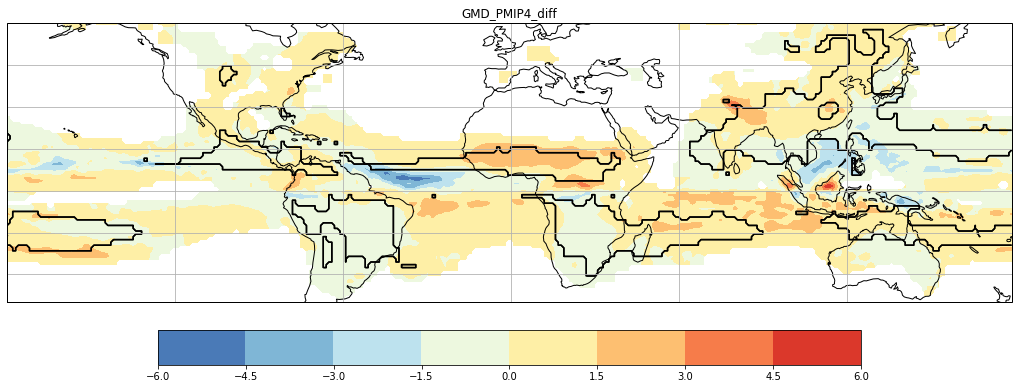

In [13]:
#Difference between the above two contour maps
# Thick contour (black) shows observed domian in present-day 
domain_diff_plot(GMD_diff,experiment_name)

In [14]:

d=Dataset('plotting_data/PMIP4_MH_monsoon_domain.nc','a')

d.variables['domain_mh'][:]=GMD_mh 
d.variables['domain_pi'][:]=GMD_pi
d.variables['domain_diff'][:]=GMD_diff
d.close()